<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/moon_nice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn import datasets
from sklearn.datasets import load_digits
from sklearn.datasets import make_moons

In [20]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)

        self.per_list = self.permutation()

    def forward(self, x):
        return self.f(x)

    def permutation(self):
        per_list =[]

        p = torch.eye(self.input_dim)
        for flow in range(self.num_flows):
            per_list.append(p[torch.randperm(p.size()[0])])

        return per_list

    def coupling_layer(self, x, m, flow, forward=True):

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a

        return z


    def f(self, x):
        z = x / torch.exp(self.s)

        for flow, model in enumerate(self.m, start=0):
            z = torch.matmul(z, self.per_list[flow])
            z = self.coupling_layer(z, model, flow, forward=True)

        log_det_j = torch.sum(self.s)         # torch.sum(self.s)

        return z, log_det_j

    def f_inv(self, z):

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            z = self.coupling_layer(z, model, flow,forward=False)
            z = torch.matmul(z, self.per_list[flow].T)

        x = z * torch.exp(self.s)
        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) - log_det_j).mean()

        return loss

In [21]:
def rescale(x, lo, hi):
    """Rescale a tensor to [lo,hi]."""
    assert(lo < hi), "[rescale] lo={0} must be smaller than hi={1}".format(lo,hi)
    old_width = torch.max(x)-torch.min(x)
    old_center = torch.min(x) + (old_width / 2.)
    new_width = float(hi-lo)
    new_center = lo + (new_width / 2.)
    # shift everything back to zero:
    x = x - old_center
    # rescale to correct width:
    x = x * (new_width / old_width)
    # shift everything to the new center:
    x = x + new_center
    # return:
    return x

In [22]:
data_dim = 2
prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))

model = NICE(input_dim=data_dim, hidden_layer=128, num_flows=10)

In [23]:
X,y = datasets.make_moons(n_samples=10000, shuffle=True, noise=0.05, random_state=1234)
x = torch.tensor(X, dtype=torch.float32)

# x = (x - x.min()) / (x.max()-x.min())
x = torch.tensor(x) + torch.rand_like(torch.tensor(x)).div_(256.)
x = rescale(x, 0., 1.).numpy()

train_loader = DataLoader(x, batch_size=2500)

<ipython-input-23-cec529cb79a3>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x) + torch.rand_like(torch.tensor(x)).div_(256.)


In [24]:
"""X,y = datasets.make_moons(n_samples=10000, shuffle=True, noise=0.05, random_state=1234)
x = torch.tensor(X, dtype=torch.float32)



train_loader = DataLoader(x, batch_size=2000)"""

'X,y = datasets.make_moons(n_samples=10000, shuffle=True, noise=0.05, random_state=1234)\nx = torch.tensor(X, dtype=torch.float32)\n\n\n\ntrain_loader = DataLoader(x, batch_size=2000)'

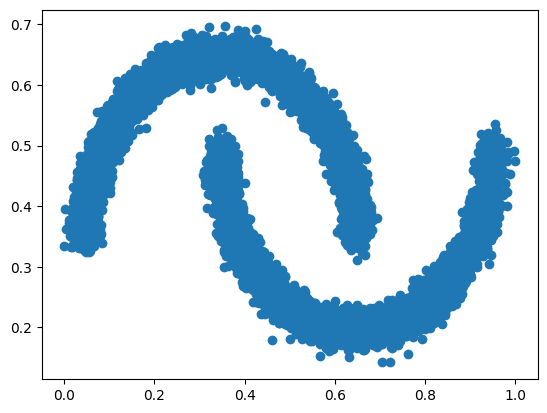

In [25]:
plt.scatter(x[:,0], x[:,1])

In [26]:
epochs = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%100 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  3.0054798126220703
Epoch :  100   -----------> Loss :  0.5954027026891708
Epoch :  200   -----------> Loss :  -1.258286714553833
Epoch :  300   -----------> Loss :  -1.8131905496120453
Epoch :  400   -----------> Loss :  -1.9446985721588135
Epoch :  500   -----------> Loss :  -1.959823727607727
Epoch :  600   -----------> Loss :  -1.9917337894439697
Epoch :  700   -----------> Loss :  -2.0150192975997925
Epoch :  800   -----------> Loss :  -2.0161080360412598
Epoch :  900   -----------> Loss :  -1.9783619344234467
Epoch :  1000   -----------> Loss :  -2.005546361207962


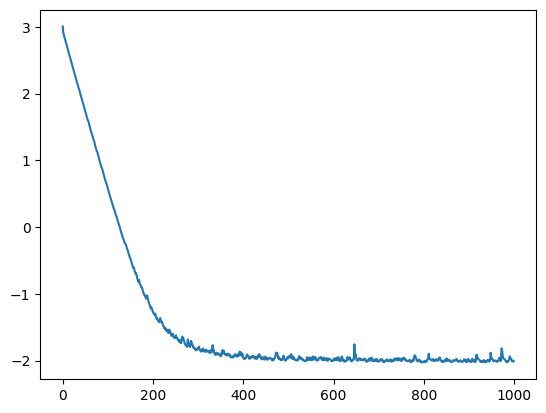

In [27]:
plt.plot(COST)

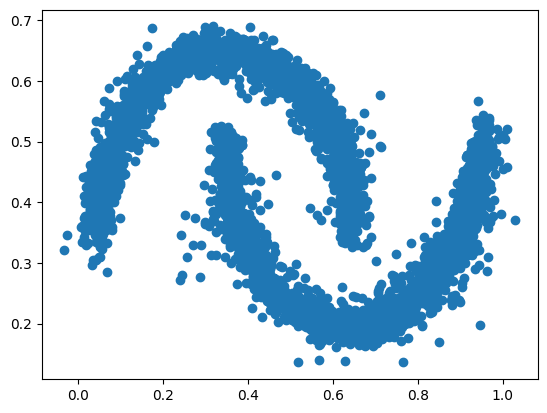

In [28]:
test = prior.sample((5000,))
sonuc = model.f_inv(test)
plt.scatter(sonuc[:,0].detach().numpy(), sonuc[:,1].detach().numpy())